In [1]:
import pandas as pd  
import numpy as np 
import matplotlib.pyplot as plt
import imageio #这个东西是用来读取tiff图片得
import seaborn as sns
import time   #时间相关的

plt.style.use('classic')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os
path = os.path.abspath(os.path.dirname(os.getcwd()) + os.path.sep + ".")
raw_data_point = path+'\LSM\PointData'     #这个是用来读取点数据路径得
raw_data_raster = path+'\LSM\RasterData2'   #这个是用来读取像素数据得
Picture_result = path+'\LSM\Picture'   #这个是用来读取像素数据得


#本处为载入将要运用的全部模型
from sklearn.model_selection import train_test_split,GridSearchCV,KFold
from sklearn.feature_selection import RFE
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.svm import LinearSVC

from sklearn.preprocessing import StandardScaler,MinMaxScaler

from sklearn.metrics import accuracy_score,mean_squared_error,roc_auc_score,roc_curve

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# 随机种子42     5折训练
SEED = 42 
NFOLDS = 5
KF = KFold(n_splits= NFOLDS,shuffle=True,random_state=SEED)

In [2]:
start = time.time()

img_n = 0
for lists in os.listdir(raw_data_raster):
    sub_path = os.path.join(raw_data_raster, lists)
    if os.path.isfile(sub_path):
        img_n = img_n+1
# 这是用来判断有多少的图片需要读取

img_size = (imageio.imread(raw_data_raster + r'\a0.tif')).shape
print('The size of image file is:',img_size,'The number of files is',img_n)

All_data = pd.DataFrame()
for i in range(img_n):   #这个表示了我们总共有21个输入玩意
    img_temp = imageio.imread(raw_data_raster + r'\a'+str(i)+'.tif')
    All_data['A'+str(i)] = img_temp.flatten()
    
for var in All_data.columns:# 这个部分主要是为了删除含有空值的玩意,~ 是为了取反值
    All_data=All_data[~All_data[var].isin([65535])]

All_data.replace({'A0': 1, 'A1': 1}, 0,inplace=True)
All_data.replace({'A0': 2, 'A1': 2}, 1,inplace=True) 
All_data.to_csv('Raster10m.csv')
end = time.time()
print('run time =',round(end-start,2),'s')

The size of image file is: (4710, 4432) The number of files is 21
run time = 245.52 s


In [6]:
All_data.describe().T[['min','max']].round(decimals=2)

,min,max
A0,0.00,1.00
A1,0.00,1.00
A2,1.00,20.00
A3,1.00,17.00
A4,1.00,12.00
A5,0.00,1002.70
A6,0.00,72.18
A7,-1.00,360.00
A8,-64.39,54.18
A9,0.00,10731.67


In [41]:
All_data.head(5).T

,43828,43829,43830,43831,43832
A0,0.000000,0.000000,0.000000,0.000000,0.000000
A1,0.000000,0.000000,0.000000,0.000000,0.000000
A2,2.000000,2.000000,2.000000,2.000000,2.000000
A3,9.000000,9.000000,9.000000,9.000000,9.000000
A4,3.000000,3.000000,3.000000,3.000000,3.000000
A5,694.000000,692.500000,691.500000,689.000000,686.000000
A6,35.156250,35.031250,38.750000,39.250000,33.218750
A7,159.625000,171.000000,169.500000,151.625000,131.000000
A8,-1.672852,0.835938,1.588867,1.170898,12.539062
A9,875.500000,865.500000,856.000000,846.000000,836.500000


In [8]:
print('Raw shape of Px1 is',len(All_data))
print('(Po1) No HLS samples:',All_data['A0'].value_counts()[0],'HLS samples:',All_data['A0'].value_counts()[1])
print('(Po1) No ELS samples:',All_data['A1'].value_counts()[0],'ELS samples:',All_data['A1'].value_counts()[1])
print("-------------------------------------------------------")

PointReadtarget = ['\Point1.txt','\Point2.txt','\Point3.txt']
PointDataName = ['All_dataPo1','All_dataPo2','All_dataPo3']

for i,name in enumerate(PointDataName):
    globals()[name] = pd.read_csv(raw_data_point+PointReadtarget[i],encoding='ascii',delimiter=',')
    globals()[name].replace(-9999,np.nan,inplace=True)
    old_length = len(globals()[name])
    globals()[name].dropna(axis=0, how='any', inplace=True)
    new_length = len(globals()[name])
    print('Raw shape of Dataset',name,'is',old_length,'New:',new_length,'delete',old_length-new_length,'rows')
    globals()[name].replace({'A0': 1, 'A1': 1}, 0,inplace=True)
    globals()[name].replace({'A0': 2, 'A1': 2}, 1,inplace=True) 
    print(name,': No HLS samples:',globals()[name]['A0'].value_counts()[0],'HLS samples:',globals()[name]['A0'].value_counts()[1])
    print(name,': No HLS samples:',globals()[name]['A1'].value_counts()[0],'HLS samples:',globals()[name]['A1'].value_counts()[1])
    print("-------------------------------------------------------")


Raw shape of Px1 is 11130632
(Po1) No HLS samples: 10450944 HLS samples: 679688
(Po1) No ELS samples: 10765038 ELS samples: 365594
-------------------------------------------------------
Raw shape of Dataset All_dataPo1 is 500000 New: 493441 delete 6559 rows
All_dataPo1 : No HLS samples: 463089 HLS samples: 30352
All_dataPo1 : No HLS samples: 477032 HLS samples: 16409
-------------------------------------------------------
Raw shape of Dataset All_dataPo2 is 121534 New: 120561 delete 973 rows
All_dataPo2 : No HLS samples: 82922 HLS samples: 37639
All_dataPo2 : No HLS samples: 98779 HLS samples: 21782
-------------------------------------------------------
Raw shape of Dataset All_dataPo3 is 16162 New: 16042 delete 120 rows
All_dataPo3 : No HLS samples: 14006 HLS samples: 2036
All_dataPo3 : No HLS samples: 9868 HLS samples: 6174
-------------------------------------------------------


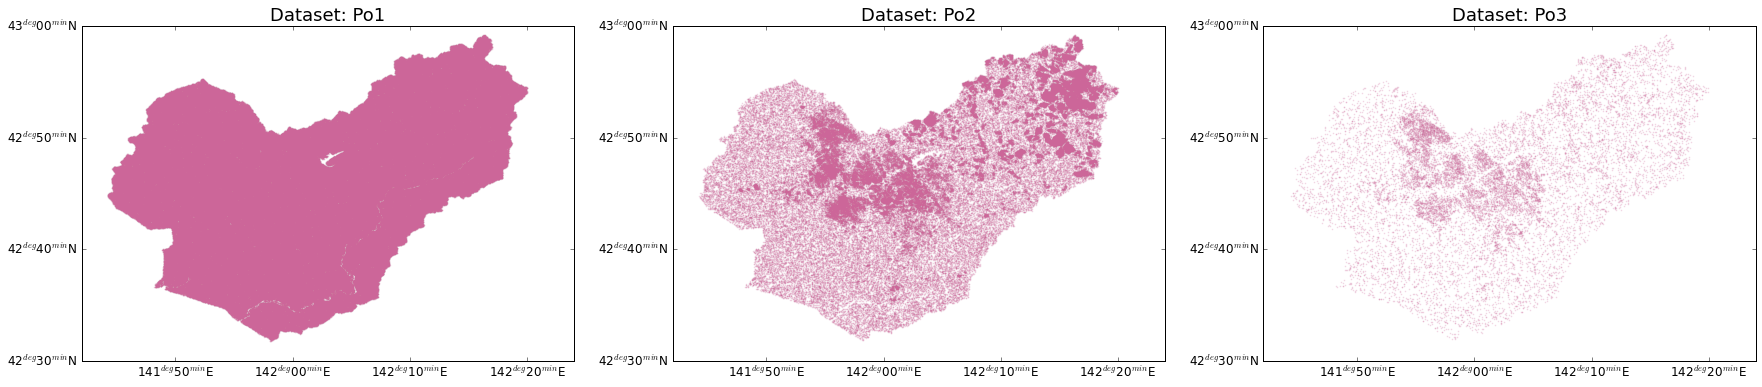

In [31]:
plt.figure(figsize=(30,6))

plt.subplot(1,3,1)
plt.title('Dataset: Po1',fontsize=18)
plt.scatter(All_dataPo1.XCoord,All_dataPo1.YCoord,marker = 'o', color = '#CC6699' ,label ='No HLS samples', s = 0.5, alpha = 1/5);

plt.xticks(np.linspace(141.5,142.5,7),
           ['141$^{deg}$30$^{min}$E','141$^{deg}$40$^{min}$E','141$^{deg}$50$^{min}$E',
            '142$^{deg}$00$^{min}$E','142$^{deg}$10$^{min}$E','142$^{deg}$20$^{min}$E','142$^{deg}$30$^{min}$E'],fontsize=12);
plt.xlim(141.7,142.4)

plt.ylim(42.5,43.0)
plt.yticks(np.linspace(42.5,43.0,4),
           ['42$^{deg}$30$^{min}$N','42$^{deg}$40$^{min}$N','42$^{deg}$50$^{min}$N','43$^{deg}$00$^{min}$N'],fontsize=12);



plt.subplot(1,3,2)
plt.title('Dataset: Po2',fontsize=18)
plt.scatter(All_dataPo2.XCoord,All_dataPo2.YCoord,marker = 'o', color = '#CC6699' ,label ='No HLS samples', s = 0.5, alpha = 1/5);

plt.xticks(np.linspace(141.5,142.5,7),
           ['141$^{deg}$30$^{min}$E','141$^{deg}$40$^{min}$E','141$^{deg}$50$^{min}$E',
            '142$^{deg}$00$^{min}$E','142$^{deg}$10$^{min}$E','142$^{deg}$20$^{min}$E','142$^{deg}$30$^{min}$E'],fontsize=12);
plt.xlim(141.7,142.4)

plt.ylim(42.5,43.0)
plt.yticks(np.linspace(42.5,43.0,4),
           ['42$^{deg}$30$^{min}$N','42$^{deg}$40$^{min}$N','42$^{deg}$50$^{min}$N','43$^{deg}$00$^{min}$N'],fontsize=12);


plt.subplot(1,3,3)
plt.title('Dataset: Po3',fontsize=18)
plt.scatter(All_dataPo3.XCoord,All_dataPo3.YCoord,marker = 'o', color = '#CC6699' ,label ='No HLS samples', s = 0.5, alpha = 1/5);

plt.xticks(np.linspace(141.5,142.5,7),
           ['141$^{deg}$30$^{min}$E','141$^{deg}$40$^{min}$E','141$^{deg}$50$^{min}$E',
            '142$^{deg}$00$^{min}$E','142$^{deg}$10$^{min}$E','142$^{deg}$20$^{min}$E','142$^{deg}$30$^{min}$E'],fontsize=12);
plt.xlim(141.7,142.4)

plt.ylim(42.5,43.0)
plt.yticks(np.linspace(42.5,43.0,4),
           ['42$^{deg}$30$^{min}$N','42$^{deg}$40$^{min}$N','42$^{deg}$50$^{min}$N','43$^{deg}$00$^{min}$N'],fontsize=12);

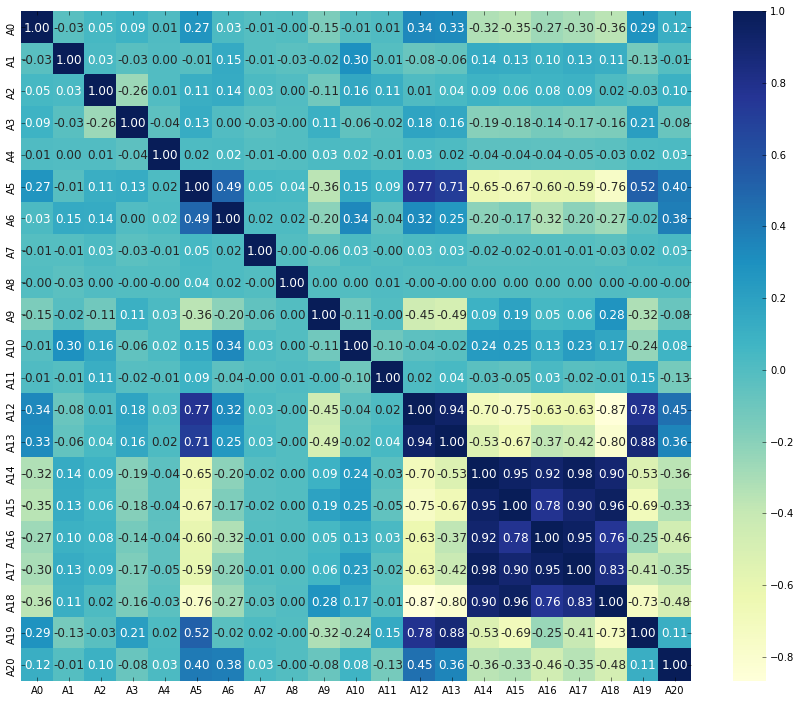

In [10]:
corrmat= All_data.corr()
f,ax=plt.subplots(figsize=(15,12))
hm = sns.heatmap(corrmat,square=True,annot=True,fmt=".2f",cmap='YlGnBu',annot_kws ={'fontsize':12});
hm.set_ylim([All_data.shape[1], 0]);

plt.savefig(Picture_result+'/'+'CorMartix.png')

In [11]:
X_col = ['A2','A3','A4']
Y_col = ['A0','A1']

with pd.ExcelWriter('CrossTable.xls') as writer:
    for Ylist in Y_col:
        for Xlist in X_col:
            locals()[Ylist+Xlist] = pd.crosstab(All_data[Xlist],All_data[Ylist],margins=True)
            locals()[Ylist+Xlist].to_excel(writer,sheet_name=Ylist+'+'+Xlist)

from functools import reduce
fn = lambda x, code=',': reduce(lambda x, y: [str(i)+code+str(j) for i in x for j in y], x)
Sheetname = fn([Y_col,X_col], "+")
print('Sheetname in xls is',Sheetname)

Sheetname in xls is ['A0+A2', 'A0+A3', 'A0+A4', 'A1+A2', 'A1+A3', 'A1+A4']


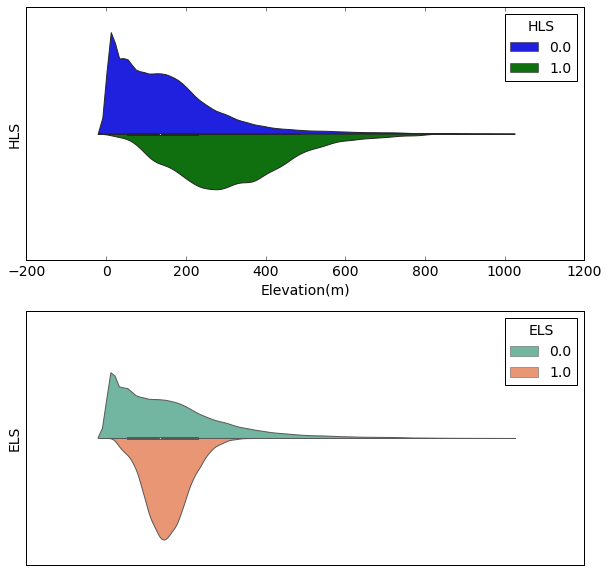

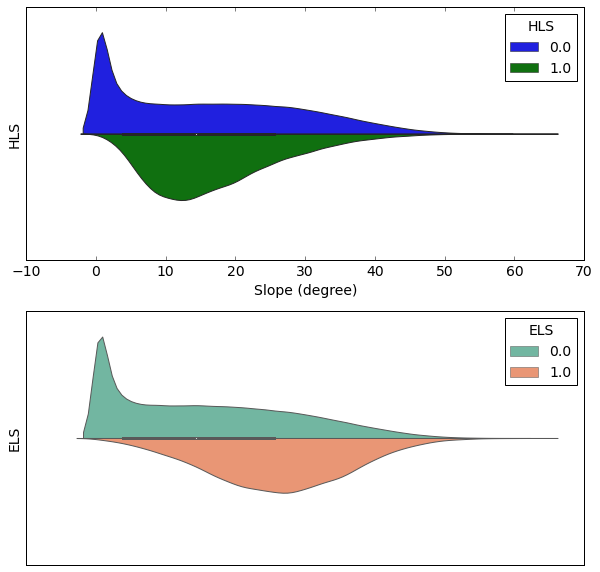

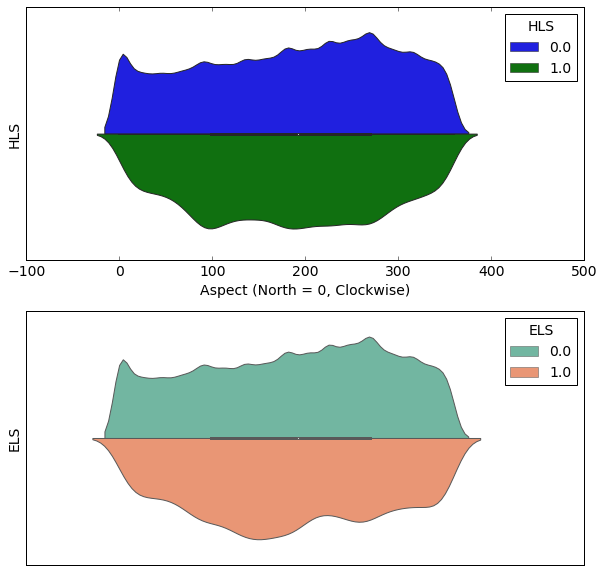

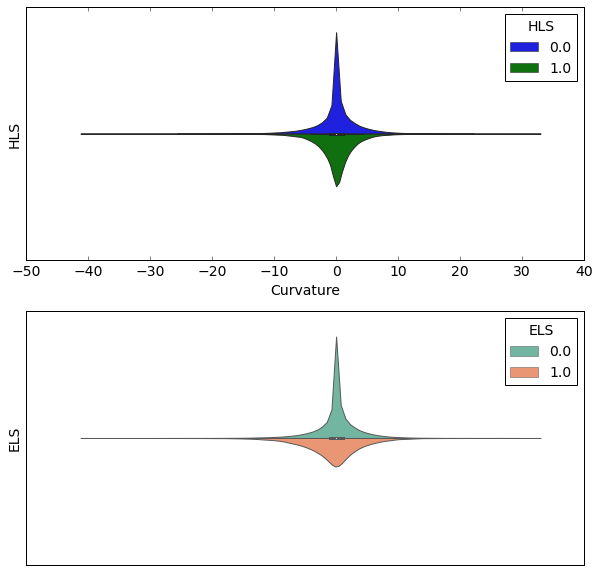

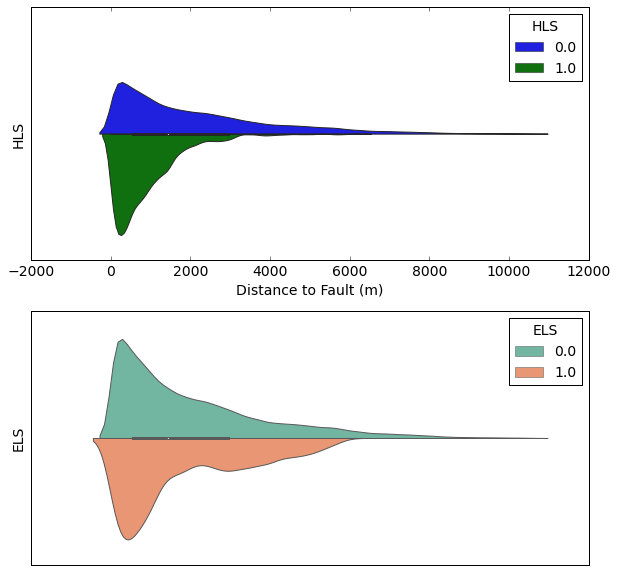

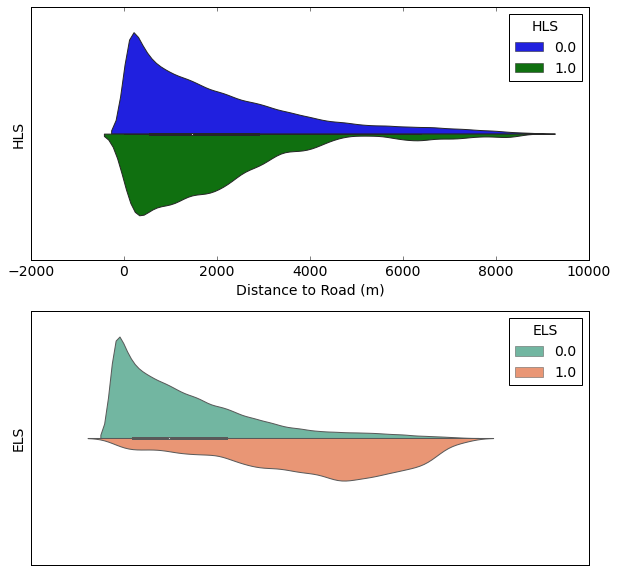

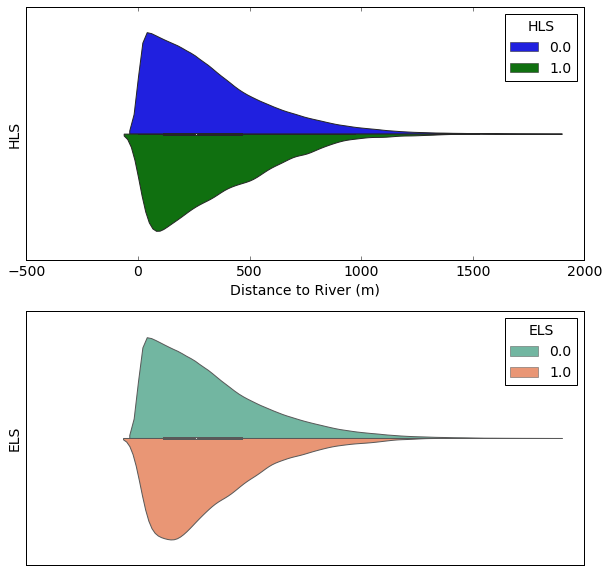

In [12]:
All_dataPo1['Fig']=1
Continuous_2LS = ['A5','A6','A7','A8','A9','A10','A11']
Continuous_name = ['Elevation(m)','Slope (degree)','Aspect (North = 0, Clockwise)',
                  'Curvature','Distance to Fault (m)','Distance to Road (m)','Distance to River (m)']


for i, var_name in enumerate(Continuous_2LS):

    plt.figure(figsize=(10,10))
    plt.subplot(2,1,1)
    sns.violinplot( x=var_name, y='Fig', hue='A0',data=All_dataPo1,split=True,orient='h')
    plt.xlabel(Continuous_name[i],fontsize=14)
    plt.xticks(fontsize=14)
    plt.yticks([])
    plt.ylabel('HLS',fontsize=14)
    plt.legend(loc = 'upper right',title='HLS',title_fontsize=14,fontsize=14)



    plt.subplot(2,1,2)
    sns.violinplot( x=var_name, y='Fig', hue='A1',data=All_dataPo1,split=True,orient='h',palette="Set2")
    plt.xlabel('')
    plt.ylabel('ELS',fontsize=14)
    plt.legend(loc = 'upper right',title='ELS',title_fontsize=14,fontsize=14)
    plt.xticks([])
    plt.yticks([])
    
    
    plt.savefig(Picture_result+'/'+var_name+'.png')

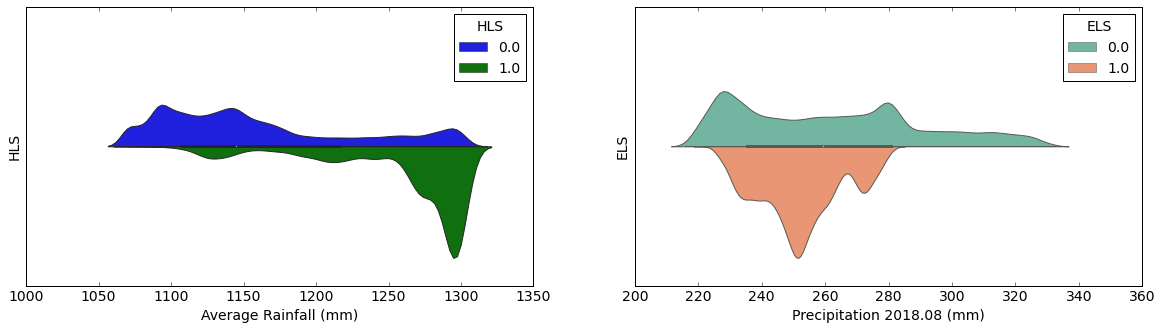

In [13]:
plt.figure(figsize=(20,5))


plt.subplot(1,2,1)
sns.violinplot( x='A12', y='Fig', hue='A0',data=All_dataPo1,split=True,orient='h')
plt.xlabel('Average Rainfall (mm)',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks([])
plt.ylabel('HLS',fontsize=14)
plt.legend(loc = 'upper right',title='HLS',title_fontsize=14,fontsize=14)



plt.subplot(1,2,2)

sns.violinplot( x='A13', y='Fig', hue='A1',data=All_dataPo1,split=True,orient='h',palette="Set2")
plt.xlabel('Precipitation 2018.08 (mm)',fontsize=14)
plt.xticks(fontsize=14)
plt.yticks([])
plt.ylabel('ELS',fontsize=14)
plt.legend(loc = 'upper right',title='ELS',title_fontsize=14,fontsize=14)

plt.savefig(Picture_result+'/'+'A12.png')

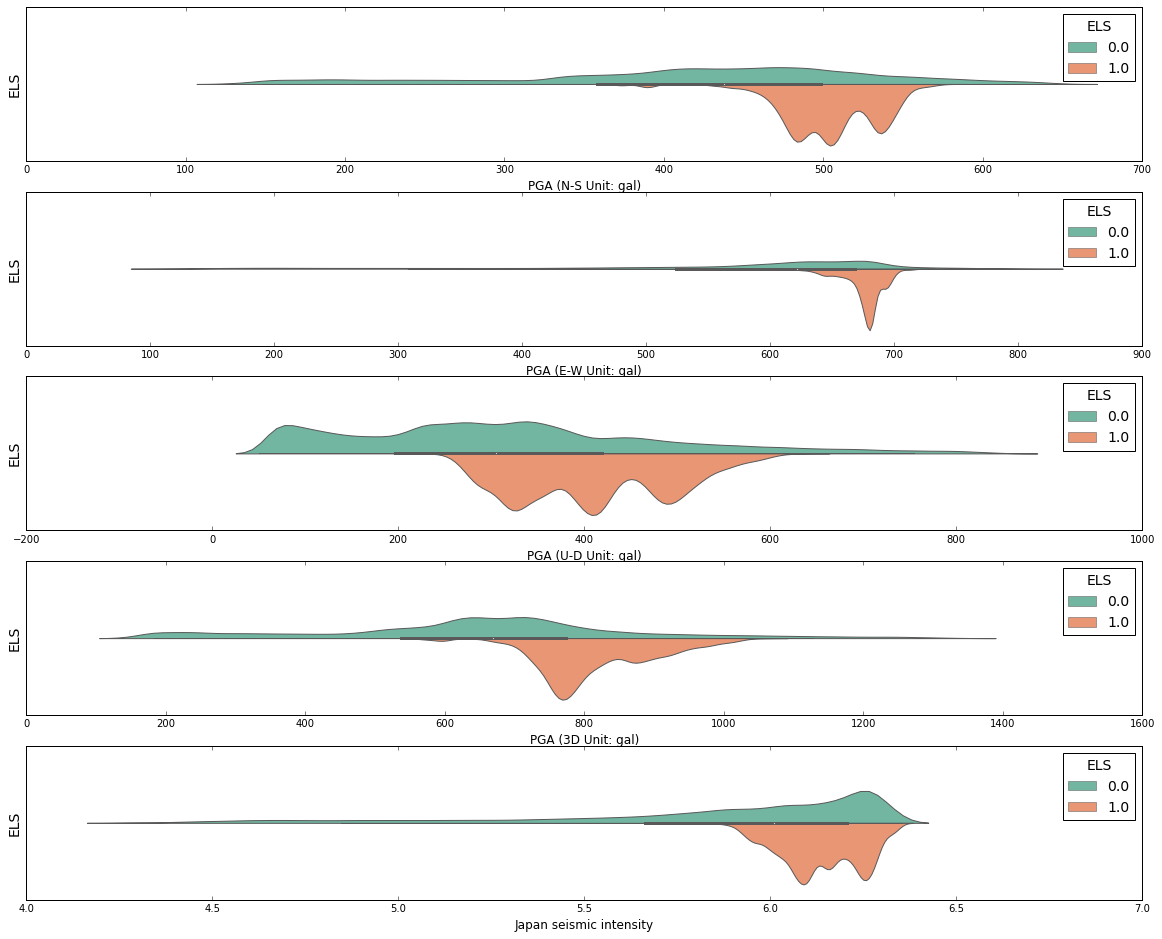

In [14]:
plt.figure(figsize=(20,16))

plt.subplot(5,1,1)
sns.violinplot(x='A14', y='Fig', hue='A1',data=All_dataPo1,split=True,orient='h',palette="Set2")
plt.xticks(fontsize=10)
plt.xlabel('PGA (N-S Unit: gal)',fontsize=12)
plt.ylabel('ELS',fontsize=14)
plt.yticks([])
plt.legend(loc = 'upper right',title='ELS',title_fontsize=14,fontsize=14)


plt.subplot(5,1,2)
sns.violinplot(x='A15', y='Fig', hue='A1',data=All_dataPo1,split=True,orient='h',palette="Set2")
plt.xticks(fontsize=10)
plt.xlabel('PGA (E-W Unit: gal)',fontsize=12)
plt.ylabel('ELS',fontsize=14)
plt.yticks([])
plt.legend(loc = 'upper right',title='ELS',title_fontsize=14,fontsize=14)

plt.subplot(5,1,3)
sns.violinplot(x='A16', y='Fig', hue='A1',data=All_dataPo1,split=True,orient='h',palette="Set2")
plt.xticks(fontsize=10)
plt.xlabel('PGA (U-D Unit: gal)',fontsize=12)
plt.ylabel('ELS',fontsize=14)
plt.yticks([])
plt.legend(loc = 'upper right',title='ELS',title_fontsize=14,fontsize=14)

plt.subplot(5,1,4)
sns.violinplot(x='A17', y='Fig', hue='A1',data=All_dataPo1,split=True,orient='h',palette="Set2")
plt.xticks(fontsize=10)
plt.xlabel('PGA (3D Unit: gal)',fontsize=12)
plt.ylabel('ELS',fontsize=14)
plt.yticks([])
plt.legend(loc = 'upper right',title='ELS',title_fontsize=14,fontsize=14)

plt.subplot(5,1,5)
sns.violinplot(x='A18', y='Fig', hue='A1',data=All_dataPo1,split=True,orient='h',palette="Set2")
plt.xticks(fontsize=10)
plt.xlabel('Japan seismic intensity',fontsize=12)
plt.ylabel('ELS',fontsize=14)
plt.yticks([])
plt.legend(loc = 'upper right',title='ELS',title_fontsize=14,fontsize=14)

plt.savefig(Picture_result+'/'+'A14-A18.png')

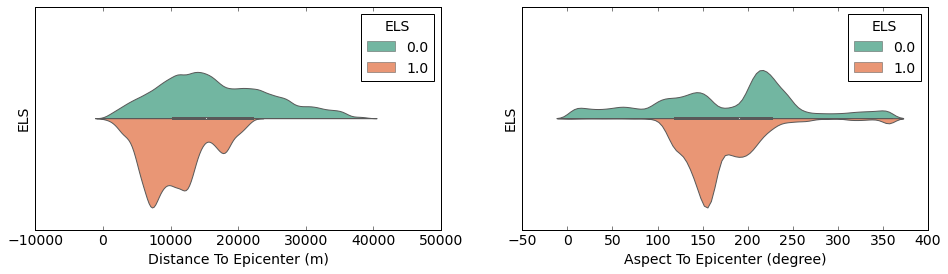

In [15]:
plt.figure(figsize=(16,4))


plt.subplot(1,2,1)
sns.violinplot( x='A19', y='Fig', hue='A1',data=All_dataPo1,split=True,orient='h',palette="Set2")
plt.xlabel('Distance To Epicenter (m)',fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('ELS',fontsize=14)
plt.yticks([])
plt.legend(loc = 'upper right',title='ELS',title_fontsize=14,fontsize=14)



plt.subplot(1,2,2)

sns.violinplot( x='A20', y='Fig', hue='A1',data=All_dataPo1,split=True,orient='h',palette="Set2")
plt.xlabel('Aspect To Epicenter (degree)',fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('ELS',fontsize=14)
plt.yticks([])
plt.legend(loc = 'upper right',title='ELS',title_fontsize=14,fontsize=14)


plt.savefig(Picture_result+'/'+'A19-A20.png')

In [16]:
def reduce_mem_usage(df):
    start_mem = df.memory_usage().sum()  / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))  
    for col in df.columns:
        col_type = df[col].dtype    
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum()  / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [17]:
All_data = reduce_mem_usage(All_data)

Memory usage of dataframe is 870.43 MB
Memory usage after optimization is: 530.75 MB
Decreased by 39.0%


In [21]:
LSM_Y =['A0']
LSM_X = ['A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','A12']
ESM_Y = ['A1']
ESM_X = ['A2','A3','A4','A5','A6','A7','A8','A9','A10','A11','A13','A14','A15','A16','A17','A18','A19','A20']

y_hls =  All_data[LSM_Y] ; y_hlsp1 = All_dataPo1[LSM_Y] ; y_hlsp2 = All_dataPo2[LSM_Y] ; y_hlsp3 = All_dataPo3[LSM_Y]
x_hls =  All_data[LSM_X] ; x_hlsp1 = All_dataPo1[LSM_X] ; x_hlsp2 = All_dataPo2[LSM_X] ; x_hlsp3 = All_dataPo3[LSM_X]
y_els =  All_data[ESM_Y] ; y_elsp1 = All_dataPo1[ESM_Y] ; y_elsp2 = All_dataPo2[ESM_Y] ; y_elsp3 = All_dataPo3[ESM_Y]
x_els =  All_data[ESM_X] ; x_elsp1 = All_dataPo1[ESM_X] ; x_elsp2 = All_dataPo2[ESM_X] ; x_elsp3 = All_dataPo3[ESM_X]

In [22]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler
print("-----------------------before the preprocessing--------------------------------")
Max_Sca = MinMaxScaler(feature_range=(0.1,0.9)).fit(x_hls).data_max_
print('The maximun of each columns',Max_Sca)
Min_Sca = MinMaxScaler(feature_range=(0.1,0.9)).fit(x_hls).data_min_
print('The minimun of each columns',Min_Sca)


print("-----------------------After the preprocessing--------------------------------")
column_index = x_hls.columns
x_hls_values = MinMaxScaler(feature_range=(0.1,0.9)).fit_transform(x_hls.values)
x_hls =pd.DataFrame(x_hls_values, columns = column_index) 


Max_Sca_after = MinMaxScaler(feature_range=(0.1,0.9)).fit(x_hls).data_max_
print('The maximun of each columns',Max_Sca_after)
Min_Sca_after = MinMaxScaler(feature_range=(0.1,0.9)).fit(x_hls).data_min_
print('The minimun of each columns',Min_Sca_after)

print("-----------------------preprocessing  Pointdata--------------------------------")

for i, column_name in enumerate(LSM_X):
    x_hlsp1[column_name] = x_hlsp1[column_name].apply(lambda X: 0.1 + 0.8*(X - Min_Sca[i])/(Max_Sca[i]-Min_Sca[i]))
    x_hlsp2[column_name] = x_hlsp2[column_name].apply(lambda X: 0.1 + 0.8*(X - Min_Sca[i])/(Max_Sca[i]-Min_Sca[i]))
    x_hlsp3[column_name] = x_hlsp3[column_name].apply(lambda X: 0.1 + 0.8*(X - Min_Sca[i])/(Max_Sca[i]-Min_Sca[i]))
    print('Factor :',column_name,'Finished')

-----------------------before the preprocessing--------------------------------
The maximun of each columns [   20.     17.     12.   1002.5    72.2   360.     54.2 10730.   9000.
  1885.   1308. ]
The minimun of each columns [ 1.000e+00  1.000e+00  1.000e+00  0.000e+00  0.000e+00 -1.000e+00
 -6.438e+01  0.000e+00  0.000e+00  0.000e+00  1.066e+03]
-----------------------After the preprocessing--------------------------------
The maximun of each columns [0.9    0.8994 0.8994 0.9    0.9    0.9    0.8994 0.9    0.9    0.9
 0.9004]
The minimun of each columns [0.1    0.1    0.1    0.1    0.1    0.1    0.1001 0.1    0.1    0.1
 0.0996]
-----------------------preprocessing  Pointdata--------------------------------
Factor : A2 Finished
Factor : A3 Finished
Factor : A4 Finished
Factor : A5 Finished
Factor : A6 Finished
Factor : A7 Finished
Factor : A8 Finished
Factor : A9 Finished
Factor : A10 Finished
Factor : A11 Finished
Factor : A12 Finished


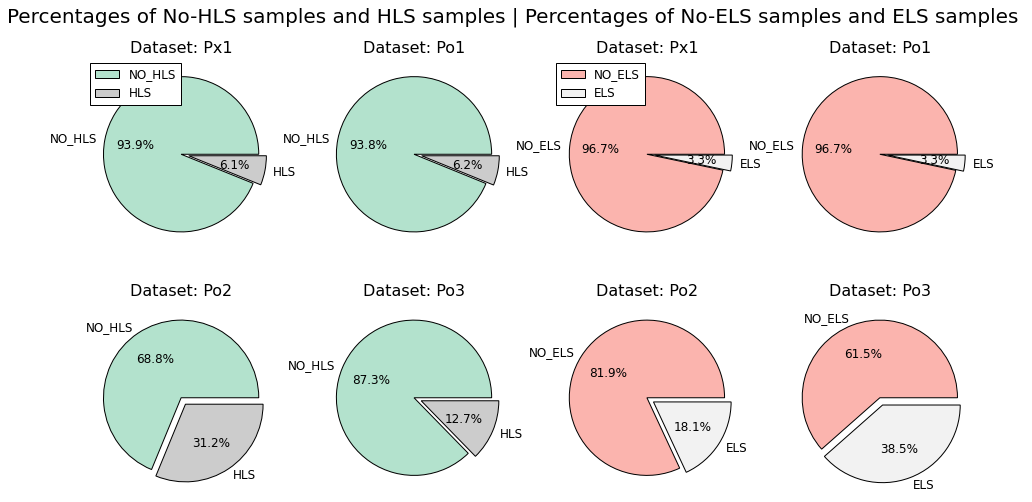

In [23]:
plt.figure(figsize=(16,8))
plt.suptitle('Percentages of No-HLS samples and HLS samples | Percentages of No-ELS samples and ELS samples ',fontsize=20)
labels1 = ['NO_HLS','HLS']
labels2 = ['NO_ELS','ELS']

plt.subplot(2,4,1)
y_hls.value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',colormap='Pastel2',fontsize=12,labels=labels1)
plt.title('Dataset: Px1',fontsize=16)
plt.legend(labels1,loc = 'upper left')
plt.ylabel("")

plt.subplot(2,4,2)
y_hlsp1.value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',colormap='Pastel2',fontsize=12,labels=labels1)
plt.title('Dataset: Po1',fontsize=16)
plt.ylabel("")

plt.subplot(2,4,5)
y_hlsp2.value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',colormap='Pastel2',fontsize=12,labels=labels1)
plt.title('Dataset: Po2',fontsize=16)
plt.ylabel("")

plt.subplot(2,4,6)
y_hlsp3.value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',colormap='Pastel2',fontsize=12,labels=labels1)    
plt.title('Dataset: Po3',fontsize=16)
plt.ylabel("")

plt.subplot(2,4,3)
y_els.value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',colormap='Pastel1',fontsize=12,labels=labels2)
plt.title('Dataset: Px1',fontsize=16)
plt.legend(labels2,loc = 'upper left')
plt.ylabel("")

plt.subplot(2,4,4)
y_elsp1.value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',colormap='Pastel1',fontsize=12,labels=labels2)
plt.title('Dataset: Po1',fontsize=16)
plt.ylabel("")

plt.subplot(2,4,7)
y_elsp2.value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',colormap='Pastel1',fontsize=12,labels=labels2)
plt.title('Dataset: Po2',fontsize=16)
plt.ylabel("")

plt.subplot(2,4,8)
y_elsp3.value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',colormap='Pastel1',fontsize=12,labels=labels2)    
plt.title('Dataset: Po3',fontsize=16)
plt.ylabel("")


plt.savefig(Picture_result+'/'+'Percentages.png')

In [24]:
def get_oof(clf, X_Train, y_Train, X_Test):
    oof_train = np.zeros((len(X_Train),))
    oof_test = np.zeros((len(X_Test),))
    oof_test_skf = np.empty((NFOLDS, len(X_Test)))
    X_Train.index = range(len(X_Train))
    y_Train.index = range(len(y_Train))
    for i, (train_index, test_index) in enumerate(KF.split(X_Train)):
        X_tr = X_Train.loc[train_index]
        y_tr = y_Train.loc[train_index]
        X_te = X_Train.loc[test_index]

        clf.fit(X_tr, y_tr)

        oof_train[test_index] = clf.predict_proba(X_te)[:,1]
        oof_test_skf[i, :] = clf.predict_proba(X_Test)[:,1]

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [25]:
%time lr_oof_train, lr_oof_test  = get_oof(LogisticRegression(), x_hls, y_hls, x_hls)
print("lr single AUC score: %.4f" % roc_auc_score(y_hls,lr_oof_train))
print("lr test AUC score: %.4f" % roc_auc_score(y_hls,lr_oof_test))

%time lr_oof_trainp1, lr_oof_testp1  = get_oof(LogisticRegression(), x_hlsp1, y_hlsp1, x_hls)
print("lr single AUC score: %.4f" % roc_auc_score(y_hlsp1,lr_oof_trainp1))
print("lr single AUC score: %.4f" % roc_auc_score(y_hls,lr_oof_testp1))

%time lr_oof_trainp2, lr_oof_testp2  = get_oof(LogisticRegression(), x_hlsp2, y_hlsp2, x_hls)
print("lr single AUC score: %.4f" % roc_auc_score(y_hlsp2,lr_oof_trainp2))
print("lr single AUC score: %.4f" % roc_auc_score(y_hls,lr_oof_testp2))

%time lr_oof_trainp3, lr_oof_testp3  = get_oof(LogisticRegression(), x_hlsp3, y_hlsp3, x_hls)
print("lr single AUC score: %.4f" % roc_auc_score(y_hlsp3,lr_oof_trainp3))
print("lr single AUC score: %.4f" % roc_auc_score(y_hls,lr_oof_testp3))   

Wall time: 3min 30s
lr single AUC score: 0.8775
lr test AUC score: 0.8775
Wall time: 12.2 s
lr single AUC score: 0.8789
lr single AUC score: 0.8774
Wall time: 6.22 s
lr single AUC score: 0.8891
lr single AUC score: 0.8772
Wall time: 4.32 s
lr single AUC score: 0.8534
lr single AUC score: 0.8677


# Test Results

The datasets' sample composition is shown in Fig 17, which means that if divided by area, the ratio of the total area of the HLS and ELS is about 6.1% and 3.3% of the total area, respectively. In Table 3, we removed samples that have missing values that come from rivers or reservoirs. It can be seen that compared to a large number of samples, removed samples only occupy a small part. Simultaneously, we used four datasets to train the untuned LR model to record the train time and then test it with the Pi1 dataset, which contains complete information in the present research. The result is that training time reduces as the sample size shrinks. Dataset Po2's performance on the test dataset Pi1 is even better than dataset Pi1 itself. Since the LR model is the simplest model among the following models we studied, if we use the dataset Pi1 to train more complex models such as RF and MLP, the time consumption will reach the hour level, adding the necessary parameters adjustment, the final calculation amount may be unbearable. In summary, we use the dataset Po2 as the training set and dataset Po1 as the testing set.